# S5 for audio denoising in fixed-point arithmetic

The model to be loaded is the best N-DNS audio denoising network, based on the S5 state space model architecture. The project is set up as:
```
├── notebook.ipynb        # Main demonstration notebook
├── data/
│   └── model_1x/          # Pre-trained model data
│       ├── fxpmodel.pkl                # Main model parameters
│       ├── fxpmodel_fxp_qconfig.pkl    # Fixed-point quantization config
│       ├── fxpmodel_io.pkl             # Input/output data
│       └── fxpmodel_modeldict.pkl      # Model dictionary
├── ndns.json             # Neural network architecture, etc.
├── fxparray.py           # Fixed-point array implementation
├── fxpmodel.py           # Fixed-point model classes (S5 in fixed-point arithmetic)
├── fxputils.py           # Utility functions for fixed-point operations
├── logging_utils.py      # Logging configuration
├── seq_model.py          # Sequential model definitions
└── ssm.py                # State Space Model implementation
```



## Load model data

In [ ]:
import jax
import os
import pickle
import sys
from pprint import pprint
from sparseRNNs.fxparray import FxpArray

data_folder = "data/model_1x"

# Create temporary alias for the old module name to fix pickle loading
import sparseRNNs.fxparray as fxparray
sys.modules['fxparray'] = fxparray

with open(f"{data_folder}/fxpmodel_fxp_qconfig.pkl", "rb") as f:
    fxp_qconfig = pickle.load(f)

with open(f"{data_folder}/fxpmodel_io.pkl", "rb") as f:
    io = pickle.load(f)

with open(f"{data_folder}/fxpmodel.pkl", "rb") as f:
    fxpmodel = pickle.load(f)
    params = fxpmodel['params']
    qconfig_verbose = fxpmodel['qconfig']

with open(f"{data_folder}/fxpmodel_modeldict.pkl", "rb") as f:
    modeldict = pickle.load(f)

# Clean up the temporary alias
del sys.modules['fxparray']

/var/folders/mq/czznxfvs7mb2w2rwvshcmxpm0000gn/T/ipykernel_93855/2982620035.py:23: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  fxpmodel = pickle.load(f)
/var/folders/mq/czznxfvs7mb2w2rwvshcmxpm0000gn/T/ipykernel_93855/2982620035.py:28: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  modeldict = pickle.load(f)


In [ ]:
import jax.numpy as np
pprint(jax.tree.map(lambda x: np.prod(np.array(x.shape)) if isinstance(x, jax.Array) and x.ndim > 0 else x, params))
nel = jax.tree.map(lambda x: np.prod(np.array(x.shape)) if isinstance(x, jax.Array) and x.ndim > 0 else x, params)
sum(jax.tree.leaves(nel))

{'decoder': {'bias': Array(257, dtype=int32),
             'weight': Array(49344, dtype=int32)},
 'encoder': {'encoder': {'bias': Array(192, dtype=int32),
                         'weight': Array(49344, dtype=int32)},
             'layers_0': {'mixer': {'A_imag': Array(128, dtype=int32),
                                    'A_real': Array(128, dtype=int32),
                                    'B_imag': Array(24576, dtype=int32),
                                    'B_real': Array(24576, dtype=int32),
                                    'C_imag': Array(24576, dtype=int32),
                                    'C_real': Array(24576, dtype=int32),
                                    'D': Array(192, dtype=int32)},
                          'norm': {'invsq_var': Array(192, dtype=int32),
                                   'mean': Array(192, dtype=int32)},
                          'out2': {'bias': Array(192, dtype=int32),
                                   'weight': Array(36864, dtype=int32)}

Array(507713, dtype=int32)

In [6]:
fxparrstr = lambda x: f"FxpArray(bits={x.bits}, exp={x.exp}, signed={x.signed}, data={x.data.shape})"
pprint(jax.tree.map(fxparrstr, io))

{'input': 'FxpArray(bits=16, exp=14, signed=True, data=(4, 3751, 257))',
 'output': 'FxpArray(bits=16, exp=12, signed=True, data=(4, 3751, 257))'}


In [7]:
pprint(jax.tree.map(lambda x: x.shape if isinstance(x, jax.Array) else x, fxp_qconfig))

{'blocks': {'multgate': {'l_absmax': 88.9554672241211,
                         'l_bits': 16,
                         'l_exp': 8,
                         'l_fracbits': 9,
                         'l_intbits': 7,
                         'l_signbits': 0.75,
                         'r_absmax': 1.0,
                         'r_bits': 16,
                         'r_exp': 14,
                         'r_fracbits': 14,
                         'r_intbits': 1,
                         'r_signbits': 0.75,
                         'res_bits': 16,
                         'res_exp': 7},
            'norm': {'invsq_var': {'bits': 16, 'exp': 6, 'intbits': 9},
                     'mean': {'bits': 16, 'exp': 14, 'intbits': 1},
                     'var': {'bits': 16, 'exp': 13, 'intbits': 2}},
            'out2': {'b_absmax': 3.45054030418396,
                     'b_bits': 16,
                     'b_exp': 9,
                     'b_fracbits': 9,
                     'b_intbits': 2,
          

In [8]:
pprint(jax.tree.map(lambda x: x.shape if isinstance(x, jax.Array) else x, params))

{'decoder': {'bias': (257,), 'weight': (192, 257)},
 'encoder': {'encoder': {'bias': (192,), 'weight': (257, 192)},
             'layers_0': {'mixer': {'A_imag': (128,),
                                    'A_real': (128,),
                                    'B_imag': (128, 192),
                                    'B_real': (128, 192),
                                    'C_imag': (192, 128),
                                    'C_real': (192, 128),
                                    'D': (192,)},
                          'norm': {'invsq_var': (192,), 'mean': (192,)},
                          'out2': {'bias': (192,), 'weight': (192, 192)}},
             'layers_1': {'mixer': {'A_imag': (128,),
                                    'A_real': (128,),
                                    'B_imag': (128, 192),
                                    'B_real': (128, 192),
                                    'C_imag': (192, 128),
                                    'C_real': (192, 128),
      

In [9]:
pprint(jax.tree.map(lambda x: x.shape if isinstance(x, jax.Array) else x, qconfig_verbose))

{'decoder': {'bias_bits': 16,
             'bias_exp': 10,
             'bias_signed': True,
             'inp_bits': 16,
             'inp_exp': 9,
             'out_bits': 16,
             'out_exp': 12,
             'weight_bits': 8,
             'weight_exp': 7,
             'weight_signed': True},
 'encoder': {'encoder': {'bias_bits': 16,
                         'bias_exp': 14,
                         'bias_signed': True,
                         'inp_bits': 16,
                         'inp_exp': 14,
                         'out_bits': 16,
                         'out_exp': 13,
                         'weight_bits': 8,
                         'weight_exp': 6,
                         'weight_signed': True},
             'layers_0': {'mixer': {'A_imag_bits': 16,
                                    'A_imag_exp': 14,
                                    'A_imag_signed': True,
                                    'A_real_bits': 16,
                                    'A_real_exp'

# Run the model

In [12]:
import json
import time
import jax.numpy as np
from functools import partial

from sparseRNNs.utils.logging import logger
from sparseRNNs.fxparray import fxp_from_fp
from sparseRNNs.fxparray import RoundingMode
from sparseRNNs.fxpmodel import FxpRegressionModel, FxpSSM, FxpS5Config
from sparseRNNs.fxputils import load_pytree, create_fxp_qconfig, load_modeldict, add_target_bits_exp, manually_overwrite
from sparseRNNs.model.ssm import QuantizationConfig

Set up the configuration for the whole model, including dimensions, quantization precisions, etc.

In [15]:
quantization = "w8a16"
recipe_fname = "recipes/ndns.json"
precisions = dict(
    non_ssm_w = 8,
    non_ssm_b = 16 if "a16" in quantization else 8,
    non_ssm_act = 16 if "a16" in quantization else 8,
    ssm_w = 8,
    ssm_act = 16 if "a16" in quantization else 8,
)
seq_len = None
fuse_batchnorm = False
relufication = True
bn_eps = 1e-5
batchsize = 1

# manually overwrite the model attributes and fxp_qconfig (not used)
manual_overwrite = {
    "model_attr": {},
    "fxp_qconfig": {},
}

# create fxp quantization configuration from modeldict
os.makedirs("./tmp", exist_ok=True)
_, fxp_qconfig = create_fxp_qconfig(modeldict, agg="max", store_json=True, json_store_folder="./tmp")
fxp_qconfig = add_target_bits_exp(modeldict, fxp_qconfig, precisions)

# setup configuration
with open(recipe_fname, "r") as f:
    recipe = json.load(f)
n_layers = max([int(e.split("_")[1]) for e in modeldict['encoder'].keys() if e.startswith('layers_')]) + 1
d_model = modeldict['encoder']['encoder']['kernel'].shape[-1]
d_ssm = modeldict['encoder']['layers_0']['mixer']['Lambda_re'].shape[0]
d_input = modeldict['encoder']['encoder']['kernel'].shape[0]
d_output = modeldict['decoder']['kernel'].shape[-1]
assert n_layers == recipe['n_layers'], f"unexpected number of layers for `{recipe['dataset']}`"
padded = recipe['dataset'] in ["imdb-classification", "listops-classification", "aan-classification"]

cfg = FxpS5Config(
    # shared configs
    q_config=QuantizationConfig.none(),  # NOTE: default
    relufication=relufication,  # fixed, required for fxp
    # SSM configs
    H=d_model,
    P=d_ssm,
    discretization="zoh",  # NOTE: default
    conj_sym=True,  # NOTE: default
    bidirectional=False,  # fixed
    associative_scan=False,  # fixed
    # model configs
    n_layers=n_layers,
    d_model=d_model,
    d_output=d_output,
    padded=padded,
    glu_variant=recipe['glu_variant'],
    bn_momentum=0.95,  # NOTE: default, never changed
    step_rescale=1.0,  # NOTE: default, never changed
    prenorm=recipe['prenorm'],  # fixed, required for fxp
    batchnorm=recipe['batchnorm'],  # fixed, required for fxp
    dropout=0.0,  # fixed, required for fxp
    training=False,  # fixed, required for fxp
    fuse_batchnorm_linear=fuse_batchnorm,
)

2025-07-12 16:18:15 [WARNING] truncate encoder.output: 14 -> 13 ( 1)
2025-07-12 16:18:15 [WARNING] truncate blocks.out2.kernel:  6 ->  5 ( 1)
2025-07-12 16:18:15 [WARNING] truncate blocks.out2.input:  9 ->  8 ( 1)
2025-07-12 16:18:15 [WARNING] truncate blocks.out2.output:  9 ->  7 ( 2)
2025-07-12 16:18:15 [WARNING] truncate decoder.kernel:  8 ->  7 ( 1)
2025-07-12 16:18:15 [WARNING] truncate decoder.input: 10 ->  9 ( 1)
2025-07-12 16:18:15 [WARNING] truncate multgate left:   9 ->  8 ( 1)
2025-07-12 16:18:15 [WARNING] truncate B_re:  8 ->  6 ( 2)
2025-07-12 16:18:15 [WARNING] truncate B_im:  9 ->  6 ( 3)
2025-07-12 16:18:15 [WARNING] truncate C_re:  5 ->  4 ( 1)
2025-07-12 16:18:15 [WARNING] truncate C_im:  6 ->  5 ( 1)
2025-07-12 16:18:15 [WARNING] truncate D   :  5 ->  4 ( 1)
2025-07-12 16:18:15 [WARNING] truncate u   :  9 ->  6 ( 3)
2025-07-12 16:18:15 [WARNING] truncate Bu_re: 10 ->  9 ( 1)
2025-07-12 16:18:15 [WARNING] truncate Bu_im: 12 ->  9 ( 3)
2025-07-12 16:18:15 [WARNING] tru

Create the model (JAX fixed-point model)

In [16]:
# setup model classes
mixer_cls = FxpSSM.init_fn(
    H=cfg.H,
    P=cfg.P,
    discretization=cfg.discretization,
    conj_sym=cfg.conj_sym,
    q_config=cfg.q_config,
    bidirectional=cfg.bidirectional,
    relufication=cfg.relufication,
    associative_scan=cfg.associative_scan,
)
model_cls = partial(
    FxpRegressionModel,
    modeldict=modeldict,
    fxp_qconfig=fxp_qconfig,
    scope="model",
    mixer_cls=mixer_cls,
    n_layers=cfg.n_layers,
    d_model=cfg.d_model,
    batchnorm=cfg.batchnorm,
    prenorm=cfg.prenorm,
    bn_momentum=cfg.bn_momentum,
    glu_variant=cfg.glu_variant,
    step_rescale=cfg.step_rescale,
    relufication=cfg.relufication,
    fuse_batchnorm_linear=cfg.fuse_batchnorm_linear,
    q_config=cfg.q_config,
    dropout=cfg.dropout,
    training=cfg.training,
    d_output=cfg.d_output,
    padded=cfg.padded,
)

In [17]:
io["input"].shape

(4, 3751, 257)

In [18]:
# setup up input
logger.info("loading inputs")
inputs = io["input"]
if batchsize > inputs.shape[0]:
    n_repeat = int(np.ceil(batchsize / inputs.shape[0]).item())
    inputs = np.repeat(inputs, n_repeat, axis=0)
    inputs = inputs[:batchsize, :, :]
elif 1 < batchsize < inputs.shape[0]:
    inputs = inputs[:batchsize, :, :]
elif batchsize == 1:
    inputs = inputs[0, :, :]
else:
    raise ValueError(f"unexpected batchsize: {batchsize}")
seq_len = seq_len if seq_len is not None else inputs.shape[0]
inputs = inputs[:seq_len, :]
fxp_inputs = inputs if isinstance(inputs, FxpArray) else fxp_from_fp(
    inputs,
    bits=fxp_qconfig['encoder']['inp_bits'],
    exp=fxp_qconfig['encoder']['inp_exp'],
    signed=True,
    round_mode=RoundingMode.FLOOR,
)

2025-07-12 16:18:19 [INFO] loading inputs


Do the actual forward pass through the model

In [19]:
model = model_cls(store_intermediates=True)
manually_overwrite(model, manual_overwrite)

logger.info("starting forward pass...")
tstart = time.time()
y = model(fxp_inputs, integration_timesteps=10)
tend = time.time()
logger.info(f"forward pass took {tend - tstart:.3f} seconds")

using shared exponents in layer 0


2025-07-12 16:18:23 [WARNING] truncate sigmoid x_exp: 7 -> 6 (1)
2025-07-12 16:18:23 [WARNING] truncate sigmoid x_exp: 7 -> 6 (1)
2025-07-12 16:18:23 [WARNING] truncate sigmoid x_exp: 7 -> 6 (1)
2025-07-12 16:18:23 [INFO] starting forward pass...


using shared exponents in layer 1
using shared exponents in layer 2


2025-07-12 16:18:24 [WARNING] .change_cfg_change_exp - overflow detected when clipping. traceback below:
2025-07-12 16:18:24 [WARNING] .change_cfg_change_exp - overflow detected when clipping. traceback below:
2025-07-12 16:18:24 [WARNING] .change_cfg_change_exp - overflow detected when clipping. traceback below:
2025-07-12 16:18:24 [INFO] forward pass took 1.089 seconds


return _run_code(code, main_globals, None, -> exec(code, run_globals) -> app.launch_new_instance() -> app.start() -> self.io_loop.start() -> self.asyncio_loop.run_forever() -> self._run_once() -> handle._run() -> self._context.run(self._callback, *self._args) -> await self.process_one() -> await dispatch(*args) -> await result -> await super().execute_request(stream, ident, parent) -> await reply_content -> shell.run_cell( -> return super().run_cell(*args, **kwargs) -> self._run_cell( -> runner(coro) -> coro.send(None) -> await self.run_ast_nodes(code_ast.body, cell_name, -> if await self.run_code(code, result, async_=asy): -> exec(code_obj, self.user_global_ns, self.user_ns) -> model(fxp_inputs, integration_timesteps=10) -> self.encoder(x, integration_timesteps) -> layer(x) -> self.norm(x) -> fxp_add( -> op1.change_cfg( -> return fxp_change_cfg( -> fxp_change_exp( -> fxp_clip(arr, do_warn=warn_on_clip, warn_prefix=f"{warn_prefix}_change_exp")
return _run_code(code, main_globals, None,

In [20]:
y

FxpArray(bits=16, exp=12, signed=True, 
         data=Array([[12058,  7868,  7672, ..., 11172, 11267, 11245],
       [11037,  5920,  6116, ..., 11140, 10562, 10509],
       [10733,  6855,  7071, ..., 12355, 11872, 11920],
       ...,
       [ 7388,   872,  -619, ...,  4571,  4855,  3889],
       [ 7063,  1318, -1118, ...,  3357,  4133,  3458],
       [ 8392,  2930,  -715, ...,  2922,  4206,  3802]], dtype=int32))

In [24]:
y.shape

(3751, 257)

In [28]:
y.data

Array([[12058,  7868,  7672, ..., 11172, 11267, 11245],
       [11037,  5920,  6116, ..., 11140, 10562, 10509],
       [10733,  6855,  7071, ..., 12355, 11872, 11920],
       ...,
       [ 7388,   872,  -619, ...,  4571,  4855,  3889],
       [ 7063,  1318, -1118, ...,  3357,  4133,  3458],
       [ 8392,  2930,  -715, ...,  2922,  4206,  3802]], dtype=int32)

In [29]:
io["output"][0].data

Array([[12020,  7804,  7584, ..., 11042, 11151, 11168],
       [11009,  5896,  6189, ..., 11059, 10507, 10477],
       [10699,  6894,  7193, ..., 12317, 11848, 11906],
       ...,
       [ 5589,   132,  -883, ...,  4258,  4916,  4015],
       [ 5066,   644, -1680, ...,  2669,  3956,  3434],
       [ 6614,  2274,  -931, ...,  2689,  4076,  3790]], dtype=int32)

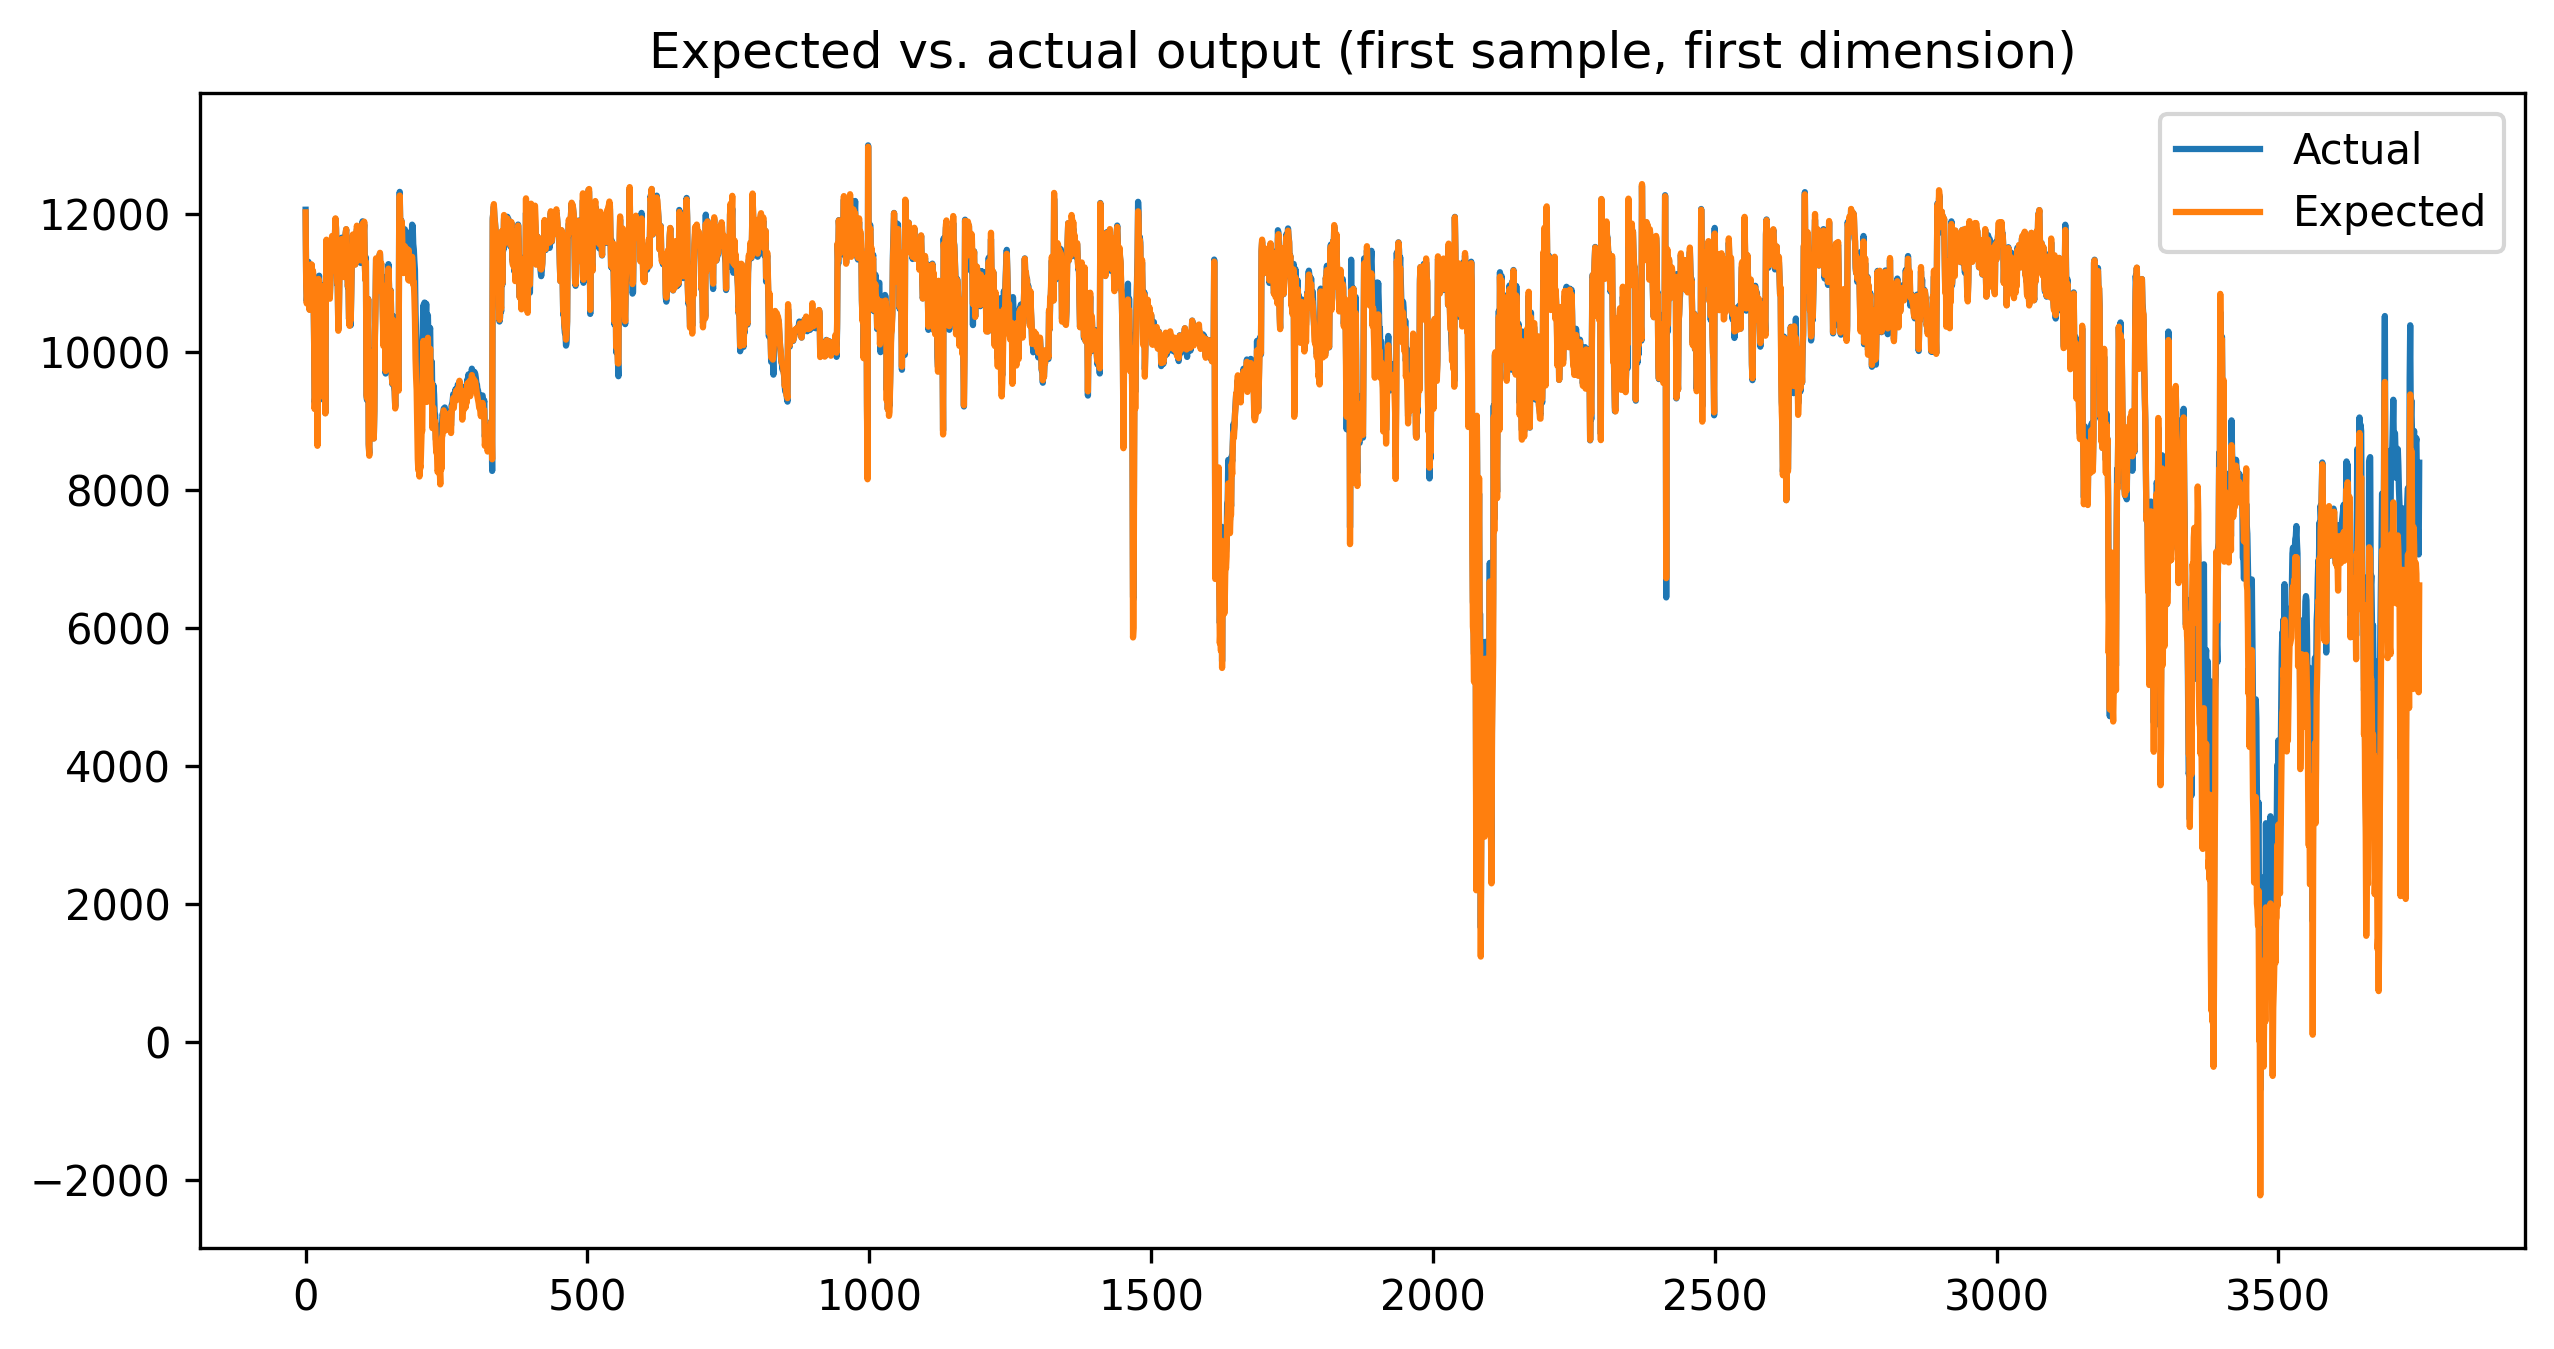

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5), dpi=300)
plt.title("Expected vs. actual output (first sample, first dimension)")
plt.plot(y[:, 0].data, label="Actual")
plt.plot(io["output"][0, :, 0].data, label="Expected")
plt.legend()
plt.show()